作業名称：pointが各学区にいくつ存在するのか算出する  
作業概要：  
メモ：入力データについて、緯度経度が存在しない場合は、XXXXにて事前に変換しておくのが望ましい

In [1]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
from geopy.distance import geodesic
import pyproj
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import rgb2hex
# from generativepy.color import Color
from PIL import ImageColor
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas.tools as gts
import os
import glob
import math
import time
import osmnx as ox
from shapely.ops import unary_union
from pathlib import Path
import fiona
import japanize_matplotlib
import folium
import sklearn
from sklearn.neighbors import BallTree
from scipy.spatial import cKDTree
import os
from pathlib import Path 

In [4]:
path_code = Path().resolve().parent
path_data = path_code.joinpath('data')
os.chdir(path_data)

## **STEP.1 集計したいエリアのshpファイル読み込み**
geoDataFrame形式で、['area_name','geometry','geometry_c']の3項目を保有するデータを作成する。  
 area_name:エリア名称  
 geometry:エリアのポリゴン  
 geometry_c:エリアの重心点  
<横須賀市(神奈川県) 小学校区のデータ元>  
https://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-A27-v3_0.html#prefecture14  
<CRSの指定>  
平面直角座標系：神奈川県 6677　https://www.inokumaaranuu.com/zahyousanshoukeiwxchange/

/var/folders/cs/q5_lgg091fd8yp4726l_ht0xl6wn_d/T/ipykernel_62980/1551464216.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_map['geometry_c'] = gdf_map['geometry'].centroid #エリアの重心点取得


number of records = 23
  area_name                                           geometry  \
0     衣笠中学校  POLYGON ((139.64666 35.24815, 139.64667 35.248...   
1     浦賀中学校  POLYGON ((139.69844 35.24474, 139.69815 35.244...   

                   geometry_c  point_node point_dist          area  
0  POINT (139.65775 35.25462)  3350250707  10.284285  2.848675e+06  
1  POINT (139.71228 35.24471)  1674559419  58.206983  4.285205e+06  


<AxesSubplot: >

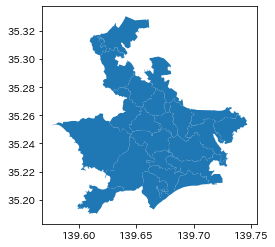

In [10]:
kbn = '中学校区'
crs_id = 6677
if '学校区' in kbn:
    if kbn == '小学校区':
        MAP_WITH_KBN_PATH = './shp/A27-21_14_GML.zip' # 小学校区
        area_col = 'A27_004'
        filter_col = 'A27_001'
        filter_val = '14201'
    elif kbn == '中学校区':
        MAP_WITH_KBN_PATH = './shp/A32-21_14_GML.zip' # 中学校区
        area_col = 'A32_004'
        filter_col = 'A32_001'
        filter_val = '14201'
    gdf_map = gpd.read_file(MAP_WITH_KBN_PATH, encoding='cp932')  # Shapefile読込
    gdf_map = gdf_map.rename(columns={area_col: 'area_name'})
    gdf_map = gdf_map[gdf_map[filter_col]==filter_val][['area_name','geometry']].copy().reset_index(drop=True)
elif kbn == '行政センター所管区域':
    MAP_DETAIL_PATH = './shp/A002005212020DDSWC14201-JGD2011.zip'
    MERGE_LIST_PATH = './area_df.csv' # 町目データの出力先
    gdf_detail_map = gpd.read_file(MAP_DETAIL_PATH, encoding='cp932')
    df_area = pd.read_csv(MERGE_LIST_PATH, encoding='cp932')  # 作成した対応表読込
    # マージの前準備
    df_area['KEY_CODE'] = df_area['KEY_CODE'].astype('int').astype('str')
    gdf_detail_map['KEY_CODE'] = gdf_detail_map['KEY_CODE'].astype('int').astype('str')
    # マージ
    gdf_detail_map = gdf_detail_map.merge(df_area[['KEY_CODE','AREA_KEY']],on='KEY_CODE')
    gdf_map = gpd.GeoDataFrame()
    gdf_map['area_name'] = None
    gdf_map['geometry'] = None
    for area_name in gdf_detail_map['AREA_KEY'].unique():
        gdf_tmp = gpd.GeoDataFrame()
        gdf_tmp['geometry'] = gpd.GeoSeries(unary_union(gdf_detail_map[gdf_detail_map['AREA_KEY']==area_name].geometry))
        gdf_tmp['area_name'] = area_name
        gdf_map = pd.concat([gdf_map,gdf_tmp], ignore_index=True)
        gdf_map = gdf_map.set_crs("EPSG:6668")


## 集計したいエリア単位のpolygon前処理(重心点算出においてはcrsが6677の方がいいかもしれないが、面積算出以外はEPSG:6668で行う。)
gdf_map['geometry_c'] = gdf_map['geometry'].centroid #エリアの重心点取得
## 道のりの長さ算出用前処理
query = "Yokosukashi,Kanagawa,Japan" 
G = ox.graph_from_place(query, network_type="drive") 
# 各エリアの重心点の最寄りノード、及びノードまでの距離取得
gdf_map['point_node'] = None
gdf_map['point_dist'] = None
for i, row  in gdf_map.iterrows():
    point_node, point_dist = ox.distance.nearest_nodes(G, row['geometry_c'].x, row['geometry_c'].y, return_dist=True)
    gdf_map.loc[i,'point_node'] = point_node # 重心点から一番近いノード
    gdf_map.loc[i,'point_dist'] = point_dist # 重心点からノードまでの距離(メートル)
if gdf_map['point_node'].isnull().sum() > 0:
    print("最寄りノードの取得失敗。道のり算出ができないエリアが存在する。")

# 面積算出
gdf_map = gdf_map.to_crs(crs_id)
gdf_map['area'] = gdf_map['geometry'].area
gdf_map = gdf_map.to_crs("EPSG:6668")

print(f'number of records = {len(gdf_map)}')  # レコード数
print(gdf_map.head(2))

# 吾妻島(azumashima)が表示されていない → 禁止米海軍の吾妻倉庫地区に属しており、一般人は原則立ち入ることができない。
gdf_map.plot()


 #### **STEP.1-1 町目単位shpファイル読み込み**
 集計したいオープンデータが国勢調査の結果などの場合、shpファイルを事前に準備しておくと良い。  
 町目の重心点が存在するエリアを町目のエリアとしてみなす。  
 <横須賀市のデータ元>  
 https://www.e-stat.go.jp/gis/statmap-search?page=2&type=2&aggregateUnitForBoundary=A&toukeiCode=00200521&toukeiYear=2020&serveyId=A002005212020&prefCode=14&coordsys=1&format=shape&datum=2000

In [11]:
MAP_DETAIL_PATH = './shp/A002005212020DDSWC14201-JGD2011.zip'
gdf_detail_map = gpd.read_file(MAP_DETAIL_PATH, encoding='cp932')  # Shapefile読込
# CRS指定
gdf_detail_map = gdf_detail_map.to_crs(crs_id)
# 面積計算（人口カバー率算出にて按分する際に使用）
gdf_detail_map['area_all'] = gdf_detail_map.area
gdf_detail_map = gdf_detail_map.to_crs("EPSG:6668")
# 中心点算出
gdf_detail_map_tmp = gpd.GeoDataFrame(gdf_detail_map[['KEY_CODE','area_all','JINKO','SETAI']], geometry=gpd.points_from_xy(gdf_detail_map['X_CODE'], gdf_detail_map['Y_CODE']))
# エリア名称取得
gdf_detail_map_tmp['area_name'] = None
for j in range(len(gdf_map)):
    poly_tmp = gdf_map.loc[j,'geometry']
    area_name = gdf_map.loc[j,'area_name']
    for k in range(len(gdf_detail_map_tmp)):
        point_tmp = gdf_detail_map_tmp.loc[k,'geometry']
        # polygonにpointが含まれるかどうか確認
        if poly_tmp.contains(point_tmp):
            # 含まれる場合に、エリア名称を獲得
            gdf_detail_map_tmp.loc[k,'area_name'] = area_name
gdf_detail_map = gdf_detail_map[['KEY_CODE','area_all','JINKO','SETAI','geometry']].merge(gdf_detail_map_tmp[['KEY_CODE','area_name']])
print(f'number of records = {len(gdf_detail_map)}')  # レコード数
gdf_detail_map.head(2)

number of records = 366


,KEY_CODE,area_all,JINKO,SETAI,geometry,area_name
0,14201001001,231918.247289,1964,790,"POLYGON ((139.65987 35.27504, 139.65985 35.274...",坂本中学校
1,14201001002,140982.598823,588,302,"POLYGON ((139.65656 35.27574, 139.65660 35.275...",坂本中学校


## **Step.2 収集したオープンデータの概況確認**    
①名称、緯度、経度、KEY_CODE(STEP.1-1で読み込んだデータと結合するキー)、住所の有無、及び欠損状況を確認する。  
 以下セルを実行すると、INPUT_DIR配下のデータについて、ファイル名称、件数、項目名称、欠損状況を確認するための資料が作成される。  
②緯度、経度/KEY_CODEが存在しないor欠損が多く使用できず、住所が使用可能な場合、以下サイトにアクセスの上、住所から緯度経度を求める。  
 https://geocode.csis.u-tokyo.ac.jp/home/csv-admatch/  
③opendt_listを作成する。  
※「利用交通手段別通勤者・通学者数（15歳以上）」などは、ダウンロードしたcsvを事前に加工する必要がある。ファイル名は英数字にしておく方が望ましい。  
※ その他、駅の情報が異なるデータに含まれる場合は、１つにまとめておく方が望ましい。（徒歩圏カバー率算出時を考慮して）


In [87]:
INPUT_DIR = '../data/opendt' # openデータ格納先
OUTPUT_FILENAME = '../data/opendt_ck.csv' # チェック結果格納先

files = sorted(glob.glob(os.path.join(INPUT_DIR,"*")))
file_list = pd.DataFrame()
for file in files:
    print(file)
    try:
        df_tmp = pd.read_csv(file,encoding='utf-8')
    except:
        df_tmp = pd.read_csv(file,encoding='cp932')
        
    # 列名をfile名称に指定
    col_name = os.path.splitext(os.path.basename(file))[0]
    file_list[col_name] = None
    file_type = os.path.splitext(os.path.basename(file))[1].replace(".","")
    rec_num = df_tmp.shape[0]
    
    file_list.loc[0,col_name] = file # PATH付きfile名称獲得
    file_list.loc[1,col_name] = file_type # fileの拡張子獲得
    file_list.loc[2,col_name]= rec_num # 件数獲得
    # col_list獲得
    i = 2
    for tmp_col in df_tmp.columns:
        i += 1
        file_list.loc[i,col_name] = tmp_col
    if file_type == "zip":
        # zip fileの場合、2行目(0行目)にカラムの日本語名称が表示されている可能性があるため
        col_name = col_name + "_02"
        file_list[col_name] = None
        file_list.loc[0,col_name] = file # PATH付きfile名称獲得
        file_list.loc[1,col_name] = file_type # fileの拡張子獲得
        file_list.loc[2,col_name]=len(df_tmp) # 件数獲得
        # col_list獲得
        i = 2
        for tmp_col in df_tmp.loc[0]:
            i += 1
            file_list.loc[i,col_name] = tmp_col
    
    # 欠損状況のチェック
    col_name = col_name + "_val"
    file_list[col_name] = None
    file_list.loc[0,col_name] = file # PATH付きfile名称獲得
    file_list.loc[1,col_name] = file_type # fileの拡張子獲得
    file_list.loc[2,col_name]=len(df_tmp) # 件数獲得
    
    # col_list獲得
    i = 2
    for tmp_col in df_tmp.columns:
        i += 1
        file_list.loc[i,col_name] = math.ceil(df_tmp[tmp_col].isnull().sum()/rec_num*100)
    
file_list.to_csv(OUTPUT_FILENAME,encoding='cp932')

../data/opendt/2020chugakko.csv
../data/opendt/2020shogakko.csv
../data/opendt/2020tosyokan_xy.csv
../data/opendt/202210syokuhin_xy.csv
../data/opendt/202211shokuhin_xy.csv
../data/opendt/bus_stop_xy.csv
../data/opendt/commuter01.csv
../data/opendt/commuter02.csv
../data/opendt/koenjouhoucsv_xy.csv
../data/opendt/metabo_hosp_xy.csv
../data/opendt/opendata_10.csv
../data/opendt/opendata_13.csv
../data/opendt/opendata_145.csv
../data/opendt/opendata_16.csv
../data/opendt/opendata_17.csv
../data/opendt/opendata_20.csv
../data/opendt/opendata_5.csv
../data/opendt/opendata_7.csv
../data/opendt/opendata_70.csv
../data/opendt/opendata_72.csv
../data/opendt/opendata_73.csv
../data/opendt/opendata_74.csv
../data/opendt/opendata_75.csv
../data/opendt/opendata_76.csv
../data/opendt/opendata_77.csv
../data/opendt/opendata_8.csv
../data/opendt/opendata_85.csv
../data/opendt/opendata_9.csv
../data/opendt/stops.csv
../data/opendt/supermarket_xy.csv
../data/opendt/syokuhin12_xy.csv
../data/opendt/tblT

## **Step.3 収集したオープンデータについて、エリア別point数、人数、世帯数などを算出する**  
1).step2で作成したopendt_listを元に、オープンデータを読み込み  
2)-1. 国勢調査関連の場合  
　①国勢調査のshpファイル(エリア情報付き)と結合  
　②エリア別に、集計すべき項目の合計を算出する (opendt_listに集計項目を記載)  
2)-2. 施設情報の場合  
　①緯度経度からPOINT(geometry)を作成する  
　②施設別に、所在エリア名称を取得する。  
　　エリアの範囲(geometry:polygon)に施設(geometry:point)が存在するか判定し、存在したらオープンデータにエリア名称を付与する  
　③エリア別に施設までの最短道のり(or距離)を算出する  
　　エリアの重心点のノードから、全施設のノードまでの道のりをそれぞれ求め、エリア別に最短となる道のりを算出する  
　④エリア別に施設からの徒歩圏(半径800m以内)カバー率を算出する  
　　全施設の半径800m円のポリゴンを結合し、各町目のポリゴンに重ねる。重ねた際の面積が算出されるので、重なった面積/all面積*人口で徒歩圏人口が算出される。  
　　エリア単位で集計し、カバー率を改めて算出する。  
　⑤エリア別に、施設の数を算出する (opendt_listの集計項目に"rec"と記載)  

In [12]:
time_sta = time.time()
## 準備作業
OUTPUT_PATH = './opendeta_cal_{}.csv'.format(kbn) # OUTPUT FILEの出力先指定
point_area_list = True # INPUTリスト別にpointとエリア名の対応表が欲しい場合はTrue 
if point_area_list:
    OUTPUT_DIR = Path('./opendt_with_{}'.format(kbn))
    OUTPUT_DIR.mkdir(exist_ok = True)
opendt_list = pd.read_csv('./opendt_list.csv',encoding='cp932') # opendt_listの読み込み
gdf_map_with_point_num = gdf_map.copy() # ベースとなるarea情報をコピー

## opendt_listに記載のある全てのdataについて、pointが各エリアにいくつ存在するのか算出する
i = -1
for point_file in range(len(opendt_list)):
    
    if point_file == i + 1:
        concat_num = opendt_list.iloc[point_file].concat_num # 公園、飲食店など、資料が分割されている場合用に、結合するファイル数を指定
        df_tmp = pd.DataFrame()
        for i in range(len(opendt_list))[point_file:point_file+concat_num]:
            INPUT_PATH = opendt_list.iloc[i].INPUT_PATH
            try:
                df_tmp00 = pd.read_csv(INPUT_PATH,encoding='utf-8')
            except:
                df_tmp00 = pd.read_csv(INPUT_PATH,encoding='cp932')
            df_tmp = pd.concat([df_tmp,df_tmp00], ignore_index=True)
        # オープンデータにおいて、抽出する場合
        if opendt_list.iloc[point_file].filter_info_exist:
            filter_col = opendt_list.iloc[point_file].filter_col
            filter_info = opendt_list.iloc[point_file].filter_info
            df_tmp = df_tmp[df_tmp[filter_col]==filter_info].reset_index()
        rec_start = opendt_list.iloc[point_file].rec_start
        df_tmp = df_tmp[rec_start:].copy()
        
        if opendt_list.iloc[point_file].kokusei_info:
            # 国勢調査の結果を使用する場合
            # KEY_CODEが存在しない場合は、市区町村コードと町丁字コードを結合して作成する
            if not opendt_list.iloc[point_file].KEY_CODE_exist:
                key_code01 = opendt_list.iloc[point_file].key_code01
                key_code02 = opendt_list.iloc[point_file].key_code02
                if pd.notna(key_code02):
                    df_tmp['KEY_CODE'] = df_tmp[key_code01].astype('str') + df_tmp[key_code02].replace("-","").str.zfill(6)
                else:
                    df_tmp['KEY_CODE'] = df_tmp[key_code01].astype('str')
            df_tmp['KEY_CODE'] = df_tmp['KEY_CODE'].astype('int').astype('str')
            # gdf_detail_mapのarea_nameとopendtの値を紐付けるためにマージ
            gdf_point = gdf_detail_map.merge(df_tmp, on='KEY_CODE')
        else:
            # 緯度経度を使用する場合
            df_tmp = df_tmp.rename(columns={opendt_list.iloc[point_file].point_name: 'point_name', 
                                    opendt_list.iloc[point_file].lng: 'lng', # 小学校が属する市区町村コード
                                    opendt_list.iloc[point_file].lat: 'lat' , # 名称
                                    })
            df_tmp = df_tmp[['point_name','lng','lat']]
            # 地理的座標系（JD2011）https://www.inokumaaranuu.com/zahyousanshoukeiwxchange/
            gdf_point = gpd.GeoDataFrame(df_tmp, geometry=gpd.points_from_xy(df_tmp['lng'], df_tmp['lat'], crs="EPSG:6668"))
            
            # 施設(point)別に、エリア名称を獲得
            # gdf_map_with_point_num,gdf_point >> "EPSG:6668"
            gdf_point['area_name'] = None
            for j in range(len(gdf_map_with_point_num)):
                poly_tmp = gdf_map_with_point_num.loc[j,'geometry']
                area_name = gdf_map_with_point_num.loc[j,'area_name']
                for k in range(len(gdf_point)):
                    point_tmp = gdf_point.loc[k,'geometry']
                    # polygonにpointが含まれるかどうか確認
                    if poly_tmp.contains(point_tmp):
                        # 含まれる場合に、エリア名称を獲得
                        gdf_point.loc[k,'area_name'] = area_name
            
            # エリアの重心から各施設までの最短道のり算出
            # gdf_map_with_point_numのnode,gdf_pointのnode >> "EPSG:6668"
            if opendt_list.iloc[point_file].dist_flg:
                dist_col = opendt_list.iloc[point_file].dist_col
                gdf_map_with_point_num[dist_col] = None
                # 各施設のnode_point取得
                gdf_point['point_node'] = None
                gdf_point['point_dist'] = None
                for j, row  in gdf_point.iterrows():
                    point_node, point_dist = ox.distance.nearest_nodes(G, row['geometry'].x, row['geometry'].y, return_dist=True)
                    gdf_point.loc[j,'point_node'] = point_node
                    gdf_point.loc[j,'point_dist'] = point_dist
                # 各エリアについて、最寄りの施設までの距離を算出する
                # 一括で求めてminをとる仕様に変換する。
                for j in range(len(gdf_map_with_point_num)):
                    area_node = None
                    area_dist = None
                    area_node = gdf_map_with_point_num.loc[j,'point_node']
                    area_dist = gdf_map_with_point_num.loc[j,'point_dist']
                    route_lengths = 9999999999
                    for k in range(len(gdf_point)):
                        fac_node = None
                        fac_dist = None
                        fac_node = gdf_point.loc[k,'point_node']
                        fac_dist = gdf_point.loc[k,'point_dist']
                        if pd.notna(fac_node):
                            shortest_path = None
                            shortest_path = ox.shortest_path(G, area_node, fac_node)
                            #print(shortest_path)
                            tmp_route_lengths = sum(ox.utils_graph.get_route_edge_attributes(G, shortest_path, "length"))
                            tmp_route_lengths += fac_dist
                            tmp_route_lengths += area_dist
                            if tmp_route_lengths < route_lengths:
                                route_lengths = tmp_route_lengths
                            gdf_map_with_point_num.loc[j,dist_col] = route_lengths
                    if route_lengths == 9999999999:
                        # 道のりが全く算出できなかった場合、距離を算出する。カラム名は「道のりのカラム名+"_02"」とする。
                        # gdf_map_with_point_num.geometry_c,gdf_point.geometry >> "EPSG:6668"
                        area_point = (gdf_map_with_point_num.loc[j,'geometry_c'].y, gdf_map_with_point_num.loc[j,'geometry_c'].x)
                        dist_col = dist_col + "_02"
                        for k in range(len(gdf_point)):
                            point_tmp = (gdf_point.loc[k,'geometry'].y,gdf_point.loc[k,'geometry'].x)
                            tmp_dist = geodesic(area_point, point_tmp).km
                            if tmp_dist < dist:
                                dist = tmp_dist
                        gdf_map_with_point_num.loc[j,dist_col] = dist
                       
            # 人口カバー率算出：半径800ｍの圏域内人口を地区の総人口で除して算出
            # 施設の半径800mのポリゴンを結合させたものを作成
            # 平面直角座標系：神奈川県 6677　https://www.inokumaaranuu.com/zahyousanshoukeiwxchange/
            # gdf_point,gdf_detail_map >> EPSG:6668 → 6677
            gdf_point = gdf_point.to_crs(crs_id)
            gdf_point.geometry = gdf_point.geometry.buffer(800)
            site = gpd.GeoDataFrame()
            # site['kbn']='all'
            site['geometry'] = gpd.GeoSeries(unary_union(gdf_point.geometry))
            site.crs = crs_id
            gdf_detail_map = gdf_detail_map.to_crs(crs_id)
            overlay = gpd.overlay(gdf_detail_map, site)
            #overlay['area'] = overlay.area
            overlay['p'] = overlay.JINKO * (overlay.area / overlay.area_all)
            overlay = overlay[['area_name','JINKO','p']].groupby(['area_name']).sum().reset_index()
            col_name=opendt_list.iloc[point_file].COL_NAME01
            col_name = col_name.replace("_num","_cover_ratio")
            overlay[col_name]= overlay['p']/overlay['JINKO']
            gdf_map_with_point_num = pd.merge(gdf_map_with_point_num,overlay[['area_name',col_name]],on='area_name',how='left')
            # gdf_point,gdf_detail_map >> 6677→EPSG:6668
        
            
        print(i,INPUT_PATH)
        
        # エリア名称を付与した資料を保存する場合
        if point_area_list:
            OUTPUT_FILENAME = os.path.splitext(os.path.basename(INPUT_PATH))[0] + '_with_area.csv'
            pd.DataFrame(gdf_point.drop(columns='geometry')).to_csv(os.path.join(OUTPUT_DIR, OUTPUT_FILENAME), encoding='cp932')
        
        # エリア別に集計
        col_names = [x for x in opendt_list.columns.to_list() if 'COL_NAME' in x] # 集計後の項目名称
        agg_col = [x for x in opendt_list.columns.to_list() if 'SUM_COL' in x] # 集計項目名称
        agg_list = zip(col_names, agg_col) # 集計後の項目名称と集計項目の名称リストを作成
        for col_name, agg_col in agg_list:
            col_name = opendt_list.iloc[point_file][col_name]
            agg_col = opendt_list.iloc[point_file][agg_col]
            if pd.notna(agg_col):
                if agg_col == 'rec':
                    # エリア名称別に件数をカウントする
                    gdf_point_agg = gdf_point['area_name'].value_counts().reset_index().copy()
                elif pd.notna(agg_col):
                    # エリア名称別にagg_colを合算する
                    gdf_point[agg_col] = gdf_point[agg_col].replace("-","0").replace("X","0")
                    gdf_point[agg_col] = gdf_point[agg_col].astype('int')
                    gdf_point_agg = gdf_point[['area_name',agg_col]].groupby(['area_name']).sum().reset_index().copy()
                gdf_point_agg.columns = ['area_name',col_name]
                # area名がNAのpointは不要のため、left joinで除外する
                gdf_map_with_point_num = gdf_map_with_point_num.merge(gdf_point_agg, on='area_name', how='left')

# 標高メッシュ情報の追加
# JGD2000なのでCRSの指定に注意
INPUT_PATH = './shp/標高メッシュ/*'
file_list = glob.glob(INPUT_PATH)
altitude_map = gpd.GeoDataFrame()
for file_name in file_list:
    altitude_map_tmp = gpd.read_file(file_name, encoding='cp932')  # Shapefile読込
    altitude_map = pd.concat([altitude_map,altitude_map_tmp]).reset_index(drop=True)
altitude_map = altitude_map[altitude_map['G04d_002']!='unknown']
altitude_map = altitude_map.set_crs("EPSG:4612")
altitude_map = altitude_map.to_crs("EPSG:6668")
altitude_map = altitude_map.reset_index()

# 標高メッシュとgdf_mapから面積按分で平均標高を算出する
gdf_map = gdf_map.to_crs(crs_id)
altitude_map = altitude_map.to_crs(crs_id)
col_name = 'altitude'
gdf_map[col_name] = None
gdf_map_tmp = pd.DataFrame()
for altitude_avg in altitude_map['G04d_002'].drop_duplicates():
    altitude_map_tmp = altitude_map[altitude_map['G04d_002']==altitude_avg][['geometry']].copy()
    if altitude_avg != None:
        site = gpd.GeoDataFrame()
        site['geometry'] = gpd.GeoSeries(unary_union(altitude_map_tmp))
        site['altitude_avg'] = altitude_avg
        site['altitude_avg'] = site['altitude_avg'].astype(float)
        site.crs = crs_id
        gdf_map = gdf_map.to_crs(crs_id)
        overlay = gpd.overlay(gdf_map, site)
        overlay['area'] = overlay.area
        gdf_map_tmp = pd.concat([gdf_map_tmp,overlay[['area_name','area','altitude_avg']]])
gdf_map_tmp['altitude_area'] = gdf_map_tmp['altitude_avg'] * gdf_map_tmp['area'] 
gdf_map_tmp = gdf_map_tmp[['area_name','altitude_area','area']].groupby(['area_name']).sum().reset_index()
gdf_map_tmp['altitude_avg'] = gdf_map_tmp['altitude_area']/gdf_map_tmp['area']
gdf_map_with_point_num = gdf_map_with_point_num.merge(gdf_map_tmp[['area_name','altitude_avg']],on='area_name',how='left')
print(gdf_map_tmp.shape)

# 標高メッシュとgdf_mapから、各メッシュの平均標高をエリアに集約して標準偏差を算出する
altitude_map = altitude_map.to_crs("EPSG:6668")
gdf_map = gdf_map.to_crs("EPSG:6668")
altitude_map['geometry'] = altitude_map['geometry'].centroid #エリアの重心点取得
#メッシュの中心点が存在するエリア特定
altitude_map['area_name'] = None
for j in range(len(gdf_map)):
    poly_tmp = gdf_map.loc[j,'geometry']
    area_name = gdf_map.loc[j,'area_name']
    for k in range(len(altitude_map)):
        point_tmp = altitude_map.loc[k,'geometry']
        # polygonにpointが含まれるかどうか確認
        if poly_tmp.contains(point_tmp):
            # 含まれる場合に、エリア名称を獲得
            altitude_map.loc[k,'area_name'] = area_name
altitude_map = altitude_map.groupby(['area_name']).agg({'G04d_002':'std'}).reset_index()
altitude_map=altitude_map.rename(columns={'G04d_002': 'altitude_std'})

gdf_map_with_point_num = pd.merge(gdf_map_with_point_num,altitude_map[['area_name','altitude_std']],on='area_name')

      
gdf_map_with_point_num = gdf_map_with_point_num.fillna(0)
pd.DataFrame(gdf_map_with_point_num.drop(columns=['geometry','geometry_c'])).to_csv(OUTPUT_PATH, encoding='cp932')
# Shapefileを出力
# OUTPUT_PATH = '../data/gdf_map_by_primaryschool.shp'
# gdf_map_with_point_num.to_file(OUTPUT_PATH, encoding='cp932')

time_end = time.time()
tim = time_end- time_sta
# 分で出力
print(tim/60)


0 ./opendt/2020shogakko.csv
1 ./opendt/2020chugakko.csv
2 ./opendt/opendata_17.csv
3 ./opendt/opendata_70.csv
4 ./opendt/opendata_72.csv
5 ./opendt/opendata_73.csv
6 ./opendt/opendata_74.csv
7 ./opendt/opendata_75.csv
8 ./opendt/opendata_76.csv
9 ./opendt/opendata_77.csv
10 ./opendt/opendata_145.csv
14 ./opendt/opendata_10.csv
15 ./opendt/opendata_13.csv
16 ./opendt/opendata_20.csv
17 ./opendt/opendata_85.csv
18 ./opendt/opendata_5.csv
19 ./opendt/stops.csv
20 ./opendt/metabo_hosp_xy.csv
23 ./opendt/syokuhin12_xy.csv
24 ./opendt/bus_stop_xy.csv
25 ./opendt/supermarket_xy.csv
26 ./opendt/2020tosyokan_xy.csv
27 ./opendt/koenjouhoucsv_xy.csv
28 ./opendt/tblT001106C14.zip
29 ./opendt/tblT001104C14.zip
30 ./opendt/tblT001082C14.zip
31 ./opendt/tblT001082C14.zip
32 ./opendt/tblT001083C14.zip
33 ./opendt/commuter01.csv
34 ./opendt/commuter02.csv
(23, 4)


/var/folders/cs/q5_lgg091fd8yp4726l_ht0xl6wn_d/T/ipykernel_62980/626286716.py:205: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  altitude_map['geometry'] = altitude_map['geometry'].centroid #エリアの重心点取得


910.3177051345507


## 行政センターと、小学校、中学校の関係確認

In [29]:
# 小学校と行政センターの関係
## 小学校のデータ取得
MAP_WITH_KBN_PATH = './opendt/2020shogakko.csv' # 小学校区
p_school_map = pd.read_csv(MAP_WITH_KBN_PATH, encoding='cp932')  # Shapefile読込
p_school_map=p_school_map.rename(columns={'名称': 'area_name'})
p_school_map = gpd.GeoDataFrame(p_school_map[['area_name']], geometry=gpd.points_from_xy(p_school_map['経度'], p_school_map['緯度'], crs="EPSG:6668"))

## 行政センターのデータ作成
MAP_DETAIL_PATH = './shp/A002005212020DDSWC14201-JGD2011.zip'
MERGE_LIST_PATH = './area_df.csv' # 町目データの出力先
gdf_detail_map = gpd.read_file(MAP_DETAIL_PATH, encoding='cp932')
df_area = pd.read_csv(MERGE_LIST_PATH, encoding='cp932')  # 作成した対応表読込
# マージの前準備
df_area['KEY_CODE'] = df_area['KEY_CODE'].astype('int').astype('str')
gdf_detail_map['KEY_CODE'] = gdf_detail_map['KEY_CODE'].astype('int').astype('str')
# マージ
gdf_detail_map = gdf_detail_map.merge(df_area[['KEY_CODE','AREA_KEY']],on='KEY_CODE')
gdf_area = gpd.GeoDataFrame()
gdf_area['area_name'] = None
gdf_area['geometry'] = None
for area_name in gdf_detail_map['AREA_KEY'].unique():
    gdf_tmp = gpd.GeoDataFrame()
    gdf_tmp['geometry'] = gpd.GeoSeries(unary_union(gdf_detail_map[gdf_detail_map['AREA_KEY']==area_name].geometry))
    gdf_tmp['area_name'] = area_name
    gdf_area = pd.concat([gdf_area,gdf_tmp], ignore_index=True)
gdf_area = gdf_area.set_crs("EPSG:6668")

##　小学校がどこの行政区に属するのか求める
p_school_map['area_name_gyosei']=None
for j in range(len(gdf_area)):
    poly_tmp = gdf_area.loc[j,'geometry']
    area_name = gdf_area.loc[j,'area_name']
    for k in range(len(p_school_map)):
        point_tmp = p_school_map.loc[k,'geometry']
        # polygonにpointが含まれるかどうか確認
        if poly_tmp.contains(point_tmp):
            # 含まれる場合に、エリア名称を獲得
            p_school_map.loc[k,'area_name_gyosei'] = area_name
pd.DataFrame(p_school_map.drop(columns=['geometry'])).to_csv('./area_gyosei_pschool.csv', encoding='cp932')
    

In [24]:
p_school_map[p_school_map['名称']=='衣笠小学校'].head(2)

,名称,geometry,area_name_gyosei
19,衣笠小学校,POINT (139.66373 35.25511),衣笠




#### **(補足) 市外の駅の方が近いケースも存在するため、念の為同県内の駅全てからの道のりについてもチェック**  
長井小学校区の重心点からは三浦市の三崎口駅が最寄りであることがわかった。open17を修正。

In [44]:
# JRデータの確認(非商用)
# https://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-N05-v2_0.html
station_list = ['三浦海岸','三崎口','東逗子','金沢八景','六浦','野島公園','海の公園南口']
station_list = ['三崎口']
STATION_MAP_PATH = '../data/N05-21_GML/N05-21_Station2.shp' # read file PATHの指定
station_map00 = gpd.read_file(STATION_MAP_PATH, encoding='cp932')  # Shapefile読込
station_map = gpd.GeoDataFrame()
for station_name in station_list:
    tmp_station_map = station_map00[station_map00['N05_011']== station_name]
    station_map = pd.concat([station_map,tmp_station_map])
station_map = station_map.reset_index(drop=True)
      
# 神奈川県に存在する駅の最寄りノード探索
# station_map = station_map[station_map['area_name01']=='神奈川県'].reset_index()
station_map['point_node'] = None
station_map['point_dist'] = None
for i, row  in station_map.iterrows():
    point_node, point_dist = ox.distance.nearest_nodes(G, row['geometry'].x, row['geometry'].y, return_dist=True)
    station_map.loc[i,'point_node'] = point_node # 重心点から一番近いノード
    station_map.loc[i,'point_dist'] = point_dist # 重心点からノードまでの距離(メートル)
if station_map['point_node'].isnull().sum() > 0:
    print("最寄りノードの取得失敗。道のり算出ができないエリアが存在する。")
    
# エリアの重心点から駅までの道のり算出（横須賀市以外）
# 横須賀市内の駅が一番近いことを確認する
gdf_map_with_point_num['station_dist_new'] = None
gdf_map_with_point_num['station_dist_name'] = None
query = "Kanagawa,Japan"
G = ox.graph_from_place(query, network_type="drive")
for j in range(len(gdf_map_with_point_num)):
    area_node = None
    area_dist = None
    area_node = gdf_map_with_point_num.loc[j,'point_node']
    area_dist = gdf_map_with_point_num.loc[j,'point_dist']
    route_lengths = 9999999999
    for k in range(len(station_map)):
        fac_node = None
        fac_dist = None
        fac_node = station_map.loc[k,'point_node']
        fac_dist = station_map.loc[k,'point_dist']
        fac_name = station_map.loc[k,'N05_011']
        if pd.notna(fac_node):
            shortest_path = None
            shortest_path = ox.shortest_path(G, area_node, fac_node)
            tmp_route_lengths = sum(ox.utils_graph.get_route_edge_attributes(G, shortest_path, "length"))
            tmp_route_lengths += fac_dist
            tmp_route_lengths += area_dist
            if tmp_route_lengths < route_lengths:
                route_lengths = tmp_route_lengths
                station_name = fac_name
            gdf_map_with_point_num.loc[j,'station_dist_new'] = route_lengths
            gdf_map_with_point_num.loc[j,'station_dist_name'] = station_name
gdf_map_with_point_num = gdf_map_with_point_num.fillna(0)
gdf_map_with_point_num['station_dist_min'] = gdf_map_with_point_num[['station02_dist','station01_dist']].min(axis=1)
gdf_map_with_point_num[['station_dist_min','station_dist_new','area_name','station_dist_name']].to_csv('../data/station_length_ck.csv',encoding='cp932')

# 三崎口駅をopen17に追加　長井小学校区の最寄駅が横須賀市内の駅でなかったため。　4826.08969399242

In [35]:
# ダミーデータを作成して、 gdf_map_with_point_numと結合
## 削除可能
import random
df = pd.read_csv('../data/area_cal_3.csv',encoding="cp932")

df_ratio = pd.DataFrame(columns=['area_name','ratio'])
for area_name in df['area_name'].drop_duplicates():
    ratio_val = random.uniform(0.2, 0.4)
    df_ratio_tmp = pd.DataFrame({'area_name': [area_name],
                                'ratio':ratio_val
                                },)
    df_ratio = pd.concat([df_ratio, df_ratio_tmp])
df = df.merge(df_ratio,how='left')
print(df.shape)

df_tmp01 = df.copy()
df_tmp01['exc_flg'] = 1
df_tmp01['selections_num'] = df_tmp01['selections_num']*df_tmp01['ratio']
df_tmp01['selections_num'] = df_tmp01['selections_num'].astype(int)

df_tmp02 = df.copy()
df_tmp02['exc_flg'] = 0
df_tmp02['selections_num_tmp'] = df_tmp02['selections_num']*df_tmp02['ratio']
df_tmp02['selections_num'] = df_tmp02['selections_num'] - df_tmp02['selections_num_tmp'].astype(int)

col_list = ['year','area_name','gender','age_group','num','selections_num','metabo_flg','hbp01_flg','hbp02_flg','exc_flg']
df = pd.concat([df_tmp01[col_list],df_tmp02[col_list]])
df.head(2)

(16100, 11)


,year,area_name,gender,age_group,num,selections_num,metabo_flg,hbp01_flg,hbp02_flg,exc_flg
0,2015,粟田小学校,male,40-44,195,12,1,1,1,1
1,2015,粟田小学校,male,45-49,302,26,1,1,1,1


## **地域別の可視化**

#### **前処理**
人口構成などについて、構成比を算出する

gdf_map_with_point_num[]

In [ ]:
gdf_map_with_point_num

#### **グラフ、表で表現する場合**

In [72]:
# 国勢調査の性別年代別人口について
# 対象カラムリスト作成
col_list = [s for s in gdf_map_with_point_num.columns.to_list() if (s.startswith("m_")) or (s.startswith("f_"))]
col_list += ['area_name']
df_plot = gdf_map_with_point_num[col_list].copy()
df_plot =  df_plot.set_index('area_name')
# カラムとして持っていたものを行持ちにする
df_plot = df_plot.stack().reset_index()
df_plot.columns = ['area_name','kbn','num']
# 年代取得（元々は５歳きざみ）
df_plot['kbn2'] = df_plot['kbn'].str[2:3]
df_plot02 = df_plot.groupby(['area_name','kbn2']).sum('num').reset_index()
df_plot03 = df_plot02[df_plot02['kbn2']!='a'].groupby(['area_name']).sum('num').reset_index()
df_plot03.columns = ['area_name','num2']
df_plot03 = pd.merge(df_plot02[df_plot02['kbn2']=='a'],df_plot03)
df_plot03['num'] = df_plot03['num'] - df_plot03['num2']
df_plot03['kbn2'] = 'other'
df_plot03 = df_plot03[['area_name','kbn2','num']]
df_plot02 = pd.concat([df_plot02,df_plot03])
df_plot02.head(2)

In [131]:
col_list = [s for s in gdf_map_with_point_num.columns.to_list() if (s.startswith("m_")) or (s.startswith("f_"))]
col_list02 = col_list.copy()

col_list02.remove('m_all_num')
col_list02.remove('f_all_num')
print(col_list02)
col_list += ['area_name']
df_plot = gdf_map_with_point_num[col_list].copy()
df_plot['other'] = df_plot[col_list02].sum(axis=1)
df_plot['all'] = df_plot[['m_all_num','f_all_num']].sum(axis=1)
df_plot['other'] = df_plot['all'] - df_plot['other']
for col_name in ['-15','16-39','40-49','50-59','60-69','70+']:
    num = col_name[:1]
    if num=="-":
        col_list02 = ['m_15mainus','f_15mainus']
    elif num=="1":
        col_list02 = ['other']
    else:
        col_list02 = [s for s in gdf_map_with_point_num.columns.to_list() if (s.startswith("m_{}".format(num))) or (s.startswith("f_{}".format(num)))]
    print(col_name,col_list02)
    df_plot[col_name] = df_plot[col_list02].sum(axis=1)


['m_15mainus', 'm_40-44', 'm_45-49', 'm_50-54', 'm_55-59', 'm_60-64', 'm_65-69', 'm_70-74', 'm_75plus', 'f_15mainus', 'f_40-44', 'f_45-49', 'f_50-54', 'f_55-59', 'f_60-64', 'f_65-69', 'f_70-74', 'f_75plus']
-15 ['m_15mainus', 'f_15mainus']
16-39 ['other']
40-49 ['m_40-44', 'm_45-49', 'f_40-44', 'f_45-49']
50-59 ['m_50-54', 'm_55-59', 'f_50-54', 'f_55-59']
60-69 ['m_60-64', 'm_65-69', 'f_60-64', 'f_65-69']
70+ ['m_70-74', 'm_75plus', 'f_70-74', 'f_75plus']


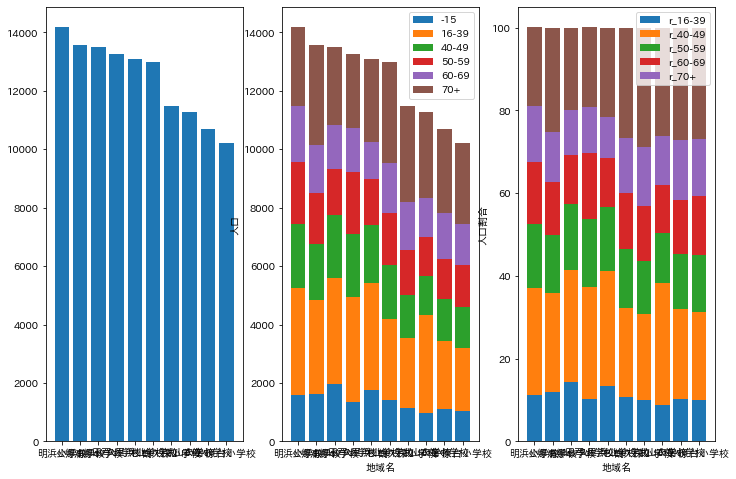

In [136]:
df_plot = df_plot[['area_name','all','-15','16-39','40-49','50-59','60-69','70+']]
df_plot_tmp = df_plot.sort_values('all',ascending=False)[:10]

for col_name in ['-15','16-39','40-49','50-59','60-69','70+']:
    col_name_new = 'r_{}'.format(col_name)
    df_plot_tmp[col_name_new] = round(100 * df_plot_tmp[col_name]/df_plot_tmp['all'],1)
    
# プロット領域の初期化(今回は1行2列の配列)
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(12, 8))

# データのプロット
ax1.bar(df_plot_tmp['area_name'], df_plot_tmp['all'], label="人口")

col_list_sum01 = []
col_list_sum02 = []
for col_name in df_plot_tmp.columns.to_list()[2:]:
    if 'r_' not in col_name:
        ax2.bar(df_plot_tmp['area_name'], df_plot_tmp[col_name],bottom=df_plot_tmp[col_list_sum01].sum(axis=1))
        col_list_sum01 += [col_name]
    else:
        ax3.bar(df_plot_tmp['area_name'], df_plot_tmp[col_name],bottom=df_plot_tmp[col_list_sum02].sum(axis=1))
        col_list_sum02 += [col_name]

ax2.set(xlabel='地域名', ylabel='人口')
ax2.legend(df_plot_tmp.columns[2:8])
ax3.set(xlabel='地域名', ylabel='人口割合')
ax3.legend(df_plot_tmp.columns[9:15])



'''
plt.bar(df_plot_tmp['area_name'], df_plot_tmp['all'], label="人口")
# 凡例の表示
plt.legend()
'''
# プロット表示(設定の反映)
plt.show()


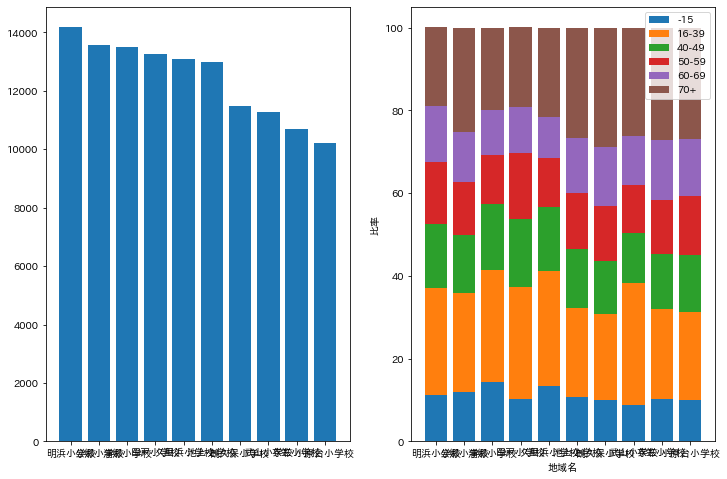

In [146]:
df_plot = df_plot[['area_name','all','-15','16-39','40-49','50-59','60-69','70+']]
df_plot_tmp = df_plot.sort_values('all',ascending=False)[:10]
col_list = []
for col_name in ['-15','16-39','40-49','50-59','60-69','70+']:
    col_name_new = 'r_{}'.format(col_name)
    df_plot_tmp[col_name_new] = round(100 * df_plot_tmp[col_name]/df_plot_tmp['all'],1)
    col_list += [col_name_new]
col_list02 = col_list.copy()
col_list02 += ['area_name']
    
# プロット領域の初期化(今回は1行2列の配列)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# データのプロット
ax1.bar(df_plot_tmp['area_name'], df_plot_tmp['all'], label="人口")
ax2 = stacked_bar(df_plot_tmp[col_list02],'area_name',col_list,ax2)

ax2.set(xlabel='地域名', ylabel='比率')
ax2.legend(df_plot_tmp.columns[2:8])


'''
plt.bar(df_plot_tmp['area_name'], df_plot_tmp['all'], label="人口")
# 凡例の表示
plt.legend()
'''
# プロット表示(設定の反映)
plt.show()


In [144]:
def stacked_bar(data,x,y,ax):
    col_list_sum = []
    for col_name in y:
        ax.bar(data[x], data[col_name],bottom=data[col_list_sum].sum(axis=1))
        col_list_sum += [col_name]
        
    return ax

In [134]:
df_plot_tmp

,area_name,all,-15,16-39,40-49,50-59,60-69,70+,r_-15,r_16-39,r_40-49,r_50-59,r_60-69,r_70+
43,明浜小学校,14175,1582,3665,2180,2124,1931,2693,0.111605,0.258554,0.153792,0.149841,0.136226,0.189982
10,公郷小学校,13551,1622,3227,1911,1744,1630,3417,0.119696,0.238137,0.141023,0.128699,0.120286,0.252159
4,浦郷小学校,13486,1948,3645,2154,1577,1500,2662,0.144446,0.270280,0.159721,0.116936,0.111226,0.197390
36,田戸小学校,13261,1353,3574,2186,2108,1493,2547,0.102029,0.269512,0.164844,0.158962,0.112586,0.192067
9,久里浜小学校,13083,1766,3643,2007,1555,1285,2827,0.134984,0.278453,0.153405,0.118857,0.098219,0.216082
29,池上小学校,12983,1402,2795,1828,1784,1732,3442,0.107987,0.215282,0.140800,0.137410,0.133405,0.265116
34,鶴久保小学校,11471,1138,2414,1455,1531,1640,3293,0.099207,0.210444,0.126842,0.133467,0.142969,0.287072
39,武山小学校,11282,985,3327,1360,1312,1337,2961,0.087307,0.294895,0.120546,0.116291,0.118507,0.262453
1,衣笠小学校,10705,1102,2327,1436,1387,1550,2903,0.102943,0.217375,0.134143,0.129566,0.144792,0.271182
16,小原台小学校,10202,1033,2150,1414,1439,1408,2758,0.101255,0.210743,0.138600,0.141051,0.138012,0.270339


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (322,) and arg 1 with shape (46,).

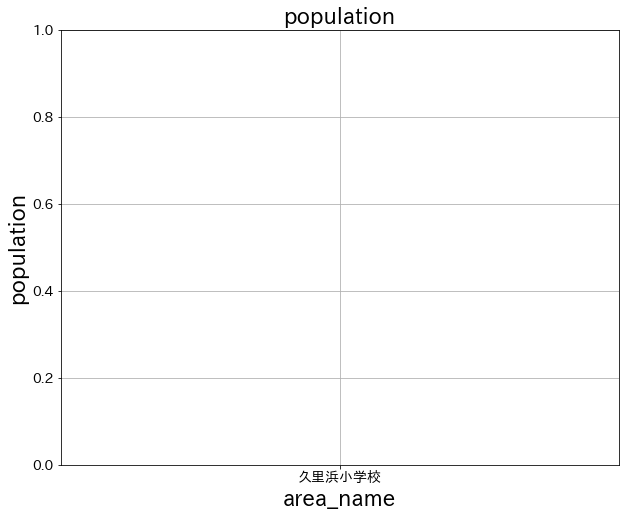

In [82]:

fig, ax = plt.subplots(figsize=(10, 8))
# データ準備
df_plot02 = df_plot02.sort_values()
area_name = df_plot02['area_name'].to_list()
population_num = df_plot02[df_plot02['kbn2']=='1']['num'].to_list()

# グラフの装飾
plt.title("population",
fontsize = 22) # (3)タイトル
plt.xlabel("area_name", fontsize = 22) # (4)x軸ラベル
plt.ylabel("population", fontsize = 22) # (5)y軸ラベル
plt.grid(True) # (6)目盛線表示
plt.tick_params(labelsize=14) # (7)目盛線ラベルサイズ
 
# グラフ描画
plt.bar(area_name, population_num, tick_label=area_name,
            align="center", color = "c") # (8)棒グラフ描画
plt.show()

In [53]:
# 自治体の実態把握
# 地域別年齢構成比と絶対数
# 高齢者の多い地域（比率＆絶対数それぞれ Top10)
col_list = []
key_list = []
col_list = [s for s in gdf_map_with_point_num.columns.to_list() if (s.startswith("m_")) or (s.startswith("f_"))]
col_list += ['area_name']
df_plot = gdf_map_with_point_num[col_list].copy()
df_plot =  df_plot.set_index('area_name')

fig, ax = plt.subplots(figsize=(10, 8))
for i in range(len(dataset)):
    ax.bar(dataset.columns, dataset.iloc[i], bottom=dataset.iloc[:i].sum())
    for j in range(len(dataset.columns)):
        plt.text(x=j, 
                 y=dataset.iloc[:i, j].sum() + (dataset.iloc[i, j] / 2), 
                 s=dataset.iloc[i, j], 
                 ha='center', 
                 va='bottom'
                )
ax.set(xlabel='支店名', ylabel='売り上げ')
ax.legend(dataset.index)
plt.show()

'''
plot_dataset = pd.DataFrame(index = dataset.index)
for col in dataset.columns:
    plot_dataset[col] = round(100 * dataset[col] / dataset[col].sum(), 1)
    
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(len(plot_dataset)):
    ax.bar(plot_dataset.columns, 
           plot_dataset.iloc[i], 
           bottom=plot_dataset.iloc[:i].sum()
          )
    for j in range(len(plot_dataset.columns)):
        plt.text(x=j, 
                 y=plot_dataset.iloc[:i, j].sum()+(plot_dataset.iloc[i, j]/2), 
                 s=f'{plot_dataset.iloc[i, j]}%', 
                 ha='center', 
                 va='bottom'
                )
ax.set(xlabel='支店名', ylabel='売り上げ')
ax.legend(plot_dataset.index)
plt.show()
'''
# 地域別受診者構成比と絶対数
# 受診者の多い地域（比率＆絶対数それぞれ Top10)

# 地域別メタボ構成比と絶対数
# メタボの多い地域（比率＆絶対数それぞれ Top10)

# 地域別運動状況の構成比と絶対数
# 運動状況の悪い地域（比率＆絶対数それぞれ Top10)

# 地域別運動施設までの距離、施設の数
# 運動施設までの距離が遠い地域（比率＆絶対数それぞれ Top10)
# 運動施設の数が少ない地域（絶対数、人口あたりの数、面積あたりの数 Top10)

# 地域別公園の数
# 公園の数が少ない地域（絶対数、人口あたりの数、面積あたりの数 Top10)


#### **地図**  
地図で表示する場合、都度gdf_map_with_point_numに値を結合して表示する。

In [191]:
df = pd.read_csv("../data/dummy_area_cal_01.csv", encoding='cp932')
df_plot = pd.merge(gdf_map_with_point_num,df[['area_name','population','dummy_kokuho','dummy_kokuho_ratio','dummy_kokuho_40over','dummy_medical_checkup','dummy_medical_checkup_ratio','dummy_metabo','dummy_metabo_ratio','dummy_metabo_yobi','dummy_not_exc','dummy_not_exc_ratio','dummy_exc_metabo','dummy_exc_not_metabo','dummy_exc_metabo_ratio','dummy_exc_not_metabo_ratio','dummy_metabo_exc']])

/usr/local/lib/python3.9/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


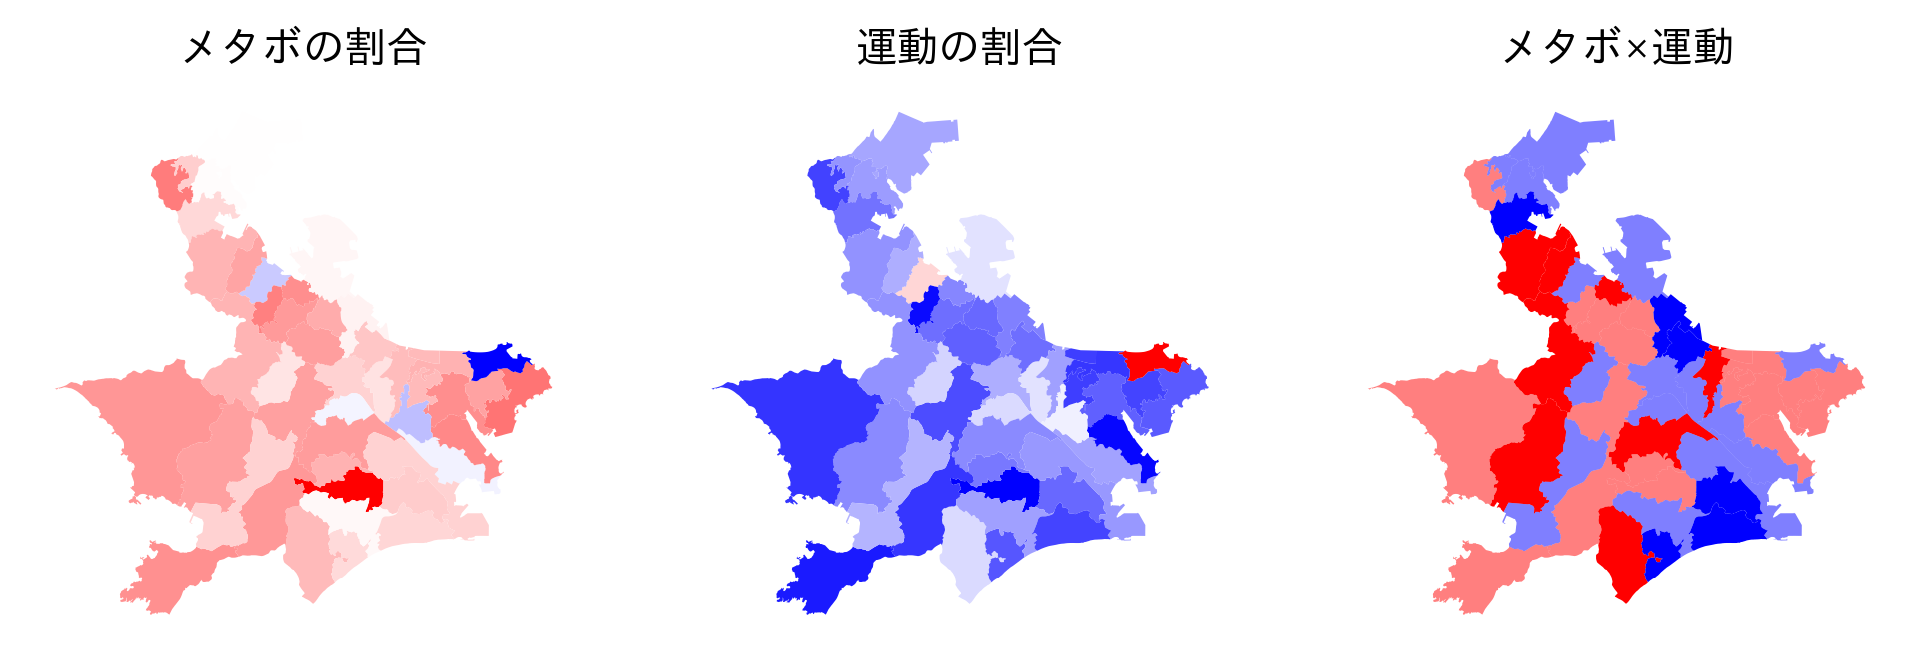

In [208]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# プロット領域の初期化(今回は1行2列の配列)
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(8,4),dpi=300)
#divider = make_axes_locatable(ax1)

# 地域別メタボ構成比と絶対数(右に表を添付する)
ax1 = df_plot.plot(column='dummy_metabo_ratio',ax=ax1, cmap="bwr", alpha=1) 
ax1.set_title("メタボの割合", fontsize=10)
ax1.axis("off")

# 地域別運動該当比該当と絶対数(右に表を添付する)
ax2 = df_plot.plot(column='dummy_not_exc_ratio',ax=ax2, cmap="bwr",alpha=1) 
ax2.set_title("運動の割合", fontsize=10)
ax2.axis("off")

# メタボと運動の組み合わせ
ax3 = df_plot[df_plot['dummy_metabo_exc']==1].plot(column='dummy_metabo_exc',ax=ax3, color="Red", alpha=1) 
ax3 = df_plot[df_plot['dummy_metabo_exc']==2].plot(column='dummy_metabo_exc',ax=ax3, color="Red", alpha=0.5) 
ax3 = df_plot[df_plot['dummy_metabo_exc']==3].plot(column='dummy_metabo_exc',ax=ax3, color="blue", alpha=0.5) 
ax3 = df_plot[df_plot['dummy_metabo_exc']==4].plot(column='dummy_metabo_exc',ax=ax3, color="blue", alpha=1) 
#ax3.legend(['高×高','高×低','低×高','低×低'])
ax3.set_title("メタボ×運動", fontsize=10)
ax3.axis("off")

# 問診と地域情報組み合わせ（公園の数）

plt.show()

In [213]:
df_plot.columns

Index(['area_name', 'geometry', 'geometry_c', 'point_node', 'point_dist',
       'school_num', 'school_dist', 'mid_school_num', 'mid_school_dist',
       'station01_num',
       ...
       'dummy_metabo', 'dummy_metabo_ratio', 'dummy_metabo_yobi',
       'dummy_not_exc', 'dummy_not_exc_ratio', 'dummy_exc_metabo',
       'dummy_exc_not_metabo', 'dummy_exc_metabo_ratio',
       'dummy_exc_not_metabo_ratio', 'dummy_metabo_exc'],
      dtype='object', length=127)

In [217]:
values = np.array([df_plot.loc[0,'dummy_metabo_ratio'],df_plot.loc[0,'dummy_metabo_ratio'],df_plot.loc[0,'dummy_metabo_ratio']])
labels = [f"データ{i}" for i in range(1, 3+1)]

In [215]:
values

array(0.693)

(139.56808749130622,
 139.75518348313722,
 35.182894638337594,
 35.337429891617575)

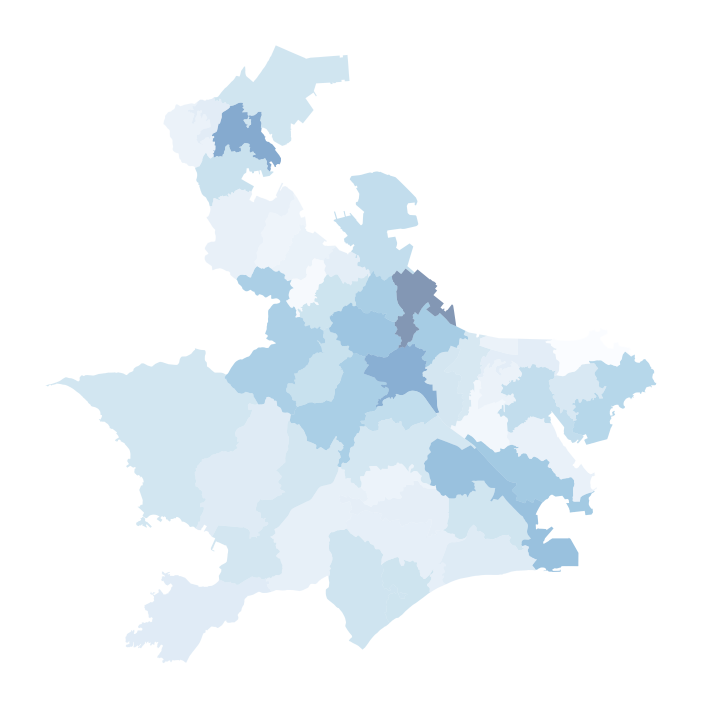

In [147]:

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8,6),dpi=150)
ax = fig.add_subplot(111)
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.1 )
ax = gdf_map_with_point_num.plot(column="single_num",ax=ax, cmap="Blues", 
                    alpha=0.5)  # scheme="quantiles"
#ax = gdf_map_with_point_num.plot(column="hospital_num",ax=ax, cmap="Reds", 
#                     alpha=0.5)  # scheme="quantiles"
#ax.set_title("振興局単位での人口", fontsize=10)
ax.axis("off")




NameError: name 'gdf_map_with_point_num' is not defined

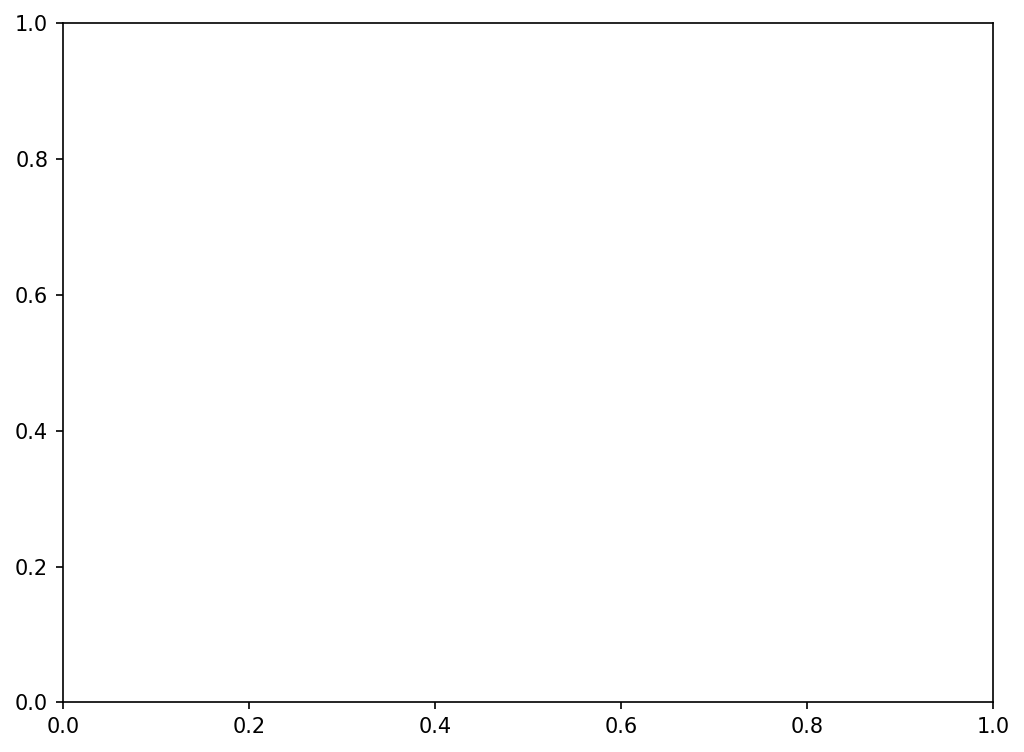

In [6]:

fig = plt.figure(figsize=(8,6),dpi=150)
ax = fig.add_subplot(111)
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.1 )
#ax = gdf_map_with_point_num.plot(column="single_num",ax=ax, cmap="Blues", 
#                    alpha=0.5)  # scheme="quantiles"
ax = gdf_map_with_point_num.plot(column="hospital_num",ax=ax, cmap="Reds", 
                     alpha=0.5)  # scheme="quantiles"
#ax.set_title("振興局単位での人口", fontsize=10)
ax.axis("off")
